Weight Models for trial_itt:
## Weight Models for Treatment Switching
## ---------------------------------------

## Weight Models for Informative Censoring
## ---------------------------------------

[[n]]
## Model: P(censor_event = 0 | X) for numerator
##  
##  term        estimate   std.error statistic p.value
##  Intercept    2.4480907 0.1405747 17.414876 6.362614e-68
##  x2           -0.4486482 0.1368779 -3.277724 1.046476e-03
##  
##  null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
##  404.2156      724     -196.7002 397.4004 403.9865 393.4004 723         725
##  
[[d0]]
## Model: P(censor_event = 0 | X, previous treatment = 0) for denominator
##  
##  term        estimate   std.error statistic p.value
##  Intercept    1.8941961 0.2071136 9.145686 5.925282e-20
##  x2           -0.5898292 0.1693423 -3.483059 4.957189e-04
##  x1           0.8552603 0.3452990 2.476869 1.325407e-02
##  
##  null.deviance df.null logLik    AIC      BIC      deviance df.resi

c:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


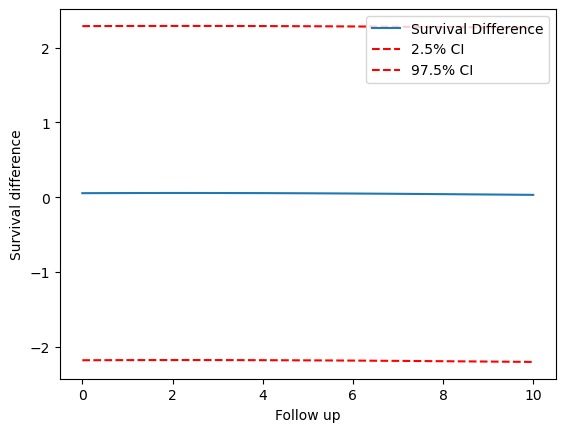

In [33]:
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pickle
import matplotlib.pyplot as plt
import warnings

# Suppress FutureWarning for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)


data_censored = pd.read_csv("data_censored.csv")


class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None
        self.switch_config = {}
        self.censor_config = {}
        self.switch_models = {}
        self.censor_models = {}
        self.outcome_model = {}
        self.expansion_options = {}
        self.expanded_data = None
        self.fitted_msm = None
        self.directory = None
        self.columns = {}

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, extra_cols=None):
        if extra_cols:
            columns = [id_col, period_col, treatment_col, outcome_col, eligible_col] + extra_cols
        else:
            columns = data.columns.tolist()
        self.data = data[columns].copy()
        self.columns = {"id": id_col, "period": period_col, "treatment": treatment_col, 
                        "outcome": outcome_col, "eligible": eligible_col}
        return self

    def set_weight_models(self, weight_type, censor_event=None, numerator_vars=None, denominator_vars=None, pool_models="none", save_path=None):
        config_key = f"{weight_type}_config"
        self.__dict__[config_key] = {
            "censor_event": censor_event,
            "numerator_vars": numerator_vars,
            "denominator_vars": denominator_vars,
            "pool_models": pool_models,
            "save_path": save_path,
            "fitted": False
        }
        return self

    def fit_weight_models(self, weight_type):
        config = self.__dict__[f"{weight_type}_config"]
        data = self.data.copy()
        models = {}
        
        if weight_type == "switch":
            data['prev_treatment'] = data.groupby('id')['treatment'].shift(1).fillna(0)
            groups = data.groupby('prev_treatment')
            outcome = 'treatment'
            formula_num = f"{outcome} ~ {' + '.join(config['numerator_vars'])}"
            formula_den = f"{outcome} ~ {' + '.join(config['denominator_vars'])}"
        elif weight_type == "censor":
            outcome = config["censor_event"]
            data[outcome] = 1 - data[outcome]  # 1 - censored
            data['prev_treatment'] = data.groupby('id')['treatment'].shift(1).fillna(0)
            if self.estimand == "ITT" and config["pool_models"] == "numerator":
                formula_num = f"{outcome} ~ {' + '.join(config['numerator_vars'])}"
                model_num = smf.glm(formula_num, data=data, family=sm.families.Binomial()).fit()
                models["pooled"] = {"numerator": model_num}
                for group_name, group_data in data.groupby('prev_treatment'):
                    formula_den = f"{outcome} ~ {' + '.join(config['denominator_vars'])}"
                    model_den = smf.glm(formula_den, data=group_data, family=sm.families.Binomial()).fit()
                    models[group_name] = {"denominator": model_den}
            else:  # PP: separate by previous treatment
                groups = data.groupby('prev_treatment')
                formula_num = f"{outcome} ~ {' + '.join(config['numerator_vars'])}"
                formula_den = f"{outcome} ~ {' + '.join(config['denominator_vars'])}"
        
        if weight_type == "switch" or (weight_type == "censor" and self.estimand == "PP"):
            for group_name, group_data in groups:
                model_num = smf.glm(formula_num, data=group_data, family=sm.families.Binomial()).fit()
                model_den = smf.glm(formula_den, data=group_data, family=sm.families.Binomial()).fit()
                models[group_name] = {"numerator": model_num, "denominator": model_den}
        
        if config["save_path"]:
            os.makedirs(config["save_path"], exist_ok=True)
            for group_name, model_dict in models.items():
                for model_type, model in model_dict.items():
                    with open(os.path.join(config["save_path"], f"model_{weight_type}_{group_name}_{model_type[0]}.pkl"), 'wb') as f:
                        pickle.dump(model, f)
        
        self.__dict__[f"{weight_type}_models"] = models
        config["fitted"] = True

    def calculate_weights(self, weight_type):
        config = self.__dict__[f"{weight_type}_config"]
        if not config["fitted"]:
            self.fit_weight_models(weight_type)
        
        data = self.data.copy()
        models = self.__dict__[f"{weight_type}_models"]
        
        if 'prev_treatment' not in data.columns:
            data['prev_treatment'] = data.groupby('id')['treatment'].shift(1).fillna(0)
        
        if weight_type == "censor" and self.estimand == "ITT" and config["pool_models"] == "numerator":
            prob_num = models["pooled"]["numerator"].predict(data)
            for prev_treatment in [0, 1]:
                group_data = data[data['prev_treatment'] == prev_treatment]
                idx = group_data.index
                prob_den = models[prev_treatment]["denominator"].predict(group_data)
                weight = prob_num.loc[idx] / prob_den
                data.loc[idx, f"{weight_type}_weight"] = weight
        else:
            for group_name, model_dict in models.items():
                group_data = data[data['prev_treatment'] == group_name]
                idx = group_data.index
                prob_num = model_dict["numerator"].predict(group_data)
                prob_den = model_dict["denominator"].predict(group_data)
                weight = prob_num / prob_den if weight_type != "switch" or group_name == 1 else (1 - prob_num) / (1 - prob_den)
                data.loc[idx, f"{weight_type}_weight"] = weight
        
        self.data = data
        return self

    def show_weight_models(self):
        for weight_type in ["switch", "censor"]:
            if f"{weight_type}_models" not in self.__dict__:
                continue
            print(f"## Weight Models for {'Treatment Switching' if weight_type == 'switch' else 'Informative Censoring'}")
            print("## ---------------------------------------\n")
            models = self.__dict__[f"{weight_type}_models"]
            for group_name, model_dict in models.items():
                group_label = str(int(group_name)) if isinstance(group_name, (int, float)) else group_name
                for model_type, model in model_dict.items():
                    if weight_type == "switch":
                        label = f"[[{model_type[0]}{group_label}]]"
                        desc = f"P(treatment = 1 | previous treatment = {group_label})"
                    elif self.estimand == "ITT" and model_type == "numerator":
                        label = "[[n]]"
                        desc = "P(censor_event = 0 | X)"
                    else:
                        label = f"[[{model_type[0]}{group_label}]]"
                        desc = f"P(censor_event = 0 | X, previous treatment = {group_label})"
                    print(label)
                    print(f"## Model: {desc} for {model_type}")
                    print("##  ")
                    print("##  term        estimate   std.error statistic p.value")
                    coef_table = model.summary2().tables[1]
                    for idx, row in coef_table.iterrows():
                        print(f"##  {idx:<12} {row['Coef.']:.7f} {row['Std.Err.']:.7f} {row['z']:.6f} {row['P>|z|']:.6e}")
                    print(f"##  ")
                    print(f"##  null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs")
                    bic = model.aic + (len(coef_table) - 1) * np.log(model.nobs)
                    print(f"##  {model.null_deviance:.4f}      {model.df_model + model.df_resid:.0f}     {model.llf:.4f} {model.aic:.4f} {bic:.4f} {model.deviance:.4f} {model.df_resid:.0f}         {model.nobs:.0f}")
                    print("##  ")

    def set_outcome_model(self, adjustment_terms=None):
        base_formula = "outcome ~ assigned_treatment + followup_time + I(followup_time**2) + trial_period + I(trial_period**2)"
        if adjustment_terms:
            self.outcome_model['formula'] = f"{base_formula} + {adjustment_terms.strip('~')}"
        else:
            self.outcome_model['formula'] = base_formula
        self.outcome_model['adjustment_terms'] = adjustment_terms
        return self

    def set_expansion_options(self, output_path, chunk_size):
        self.expansion_options = {'output_path': output_path, 'chunk_size': chunk_size}
        return self

    def expand_trials(self):
        expanded = []
        for trial_period in self.data['period'].unique():
            trial_data = self.data[self.data['period'] >= trial_period].copy()
            trial_data['trial_period'] = trial_period
            trial_data['followup_time'] = trial_data['period'] - trial_period
            trial_data['assigned_treatment'] = trial_data['treatment']
            trial_data['weight'] = trial_data.get('censor_weight', 1.0) * trial_data.get('switch_weight', 1.0)
            expanded.append(trial_data)
        self.expanded_data = pd.concat(expanded, ignore_index=True)
        self.expanded_data.to_csv(self.expansion_options['output_path'], index=False)
        return self

    def load_expanded_data(self, seed=None, p_control=None):
        if seed is not None:
            np.random.seed(seed)
        if p_control is not None:
            control_mask = (self.expanded_data['outcome'] == 0)
            sampled_controls = self.expanded_data[control_mask].sample(frac=p_control)
            cases = self.expanded_data[~control_mask]
            self.expanded_data = pd.concat([cases, sampled_controls], ignore_index=True)
        return self

    def fit_msm(self, weight_cols=None, modify_weights=None):
        if weight_cols is None:
            weight_cols = ['weight']
        weights = self.expanded_data[weight_cols[0]].copy()
        if modify_weights:
            weights = modify_weights(weights)
        self.fitted_msm = smf.glm(self.outcome_model['formula'], self.expanded_data, family=sm.families.Binomial(), weights=weights).fit()
        print("Model Summary:")
        print(self.fitted_msm.summary())
        return self

    def predict(self, newdata, predict_times, type="survival"):
        predictions = {}
        base_data = newdata.drop(columns=['outcome', 'treatment', 'period', 'followup_time', 'assigned_treatment']).mean()
        trial_period = newdata['trial_period'].iloc[0]
        
        for treatment in [0, 1]:
            pred_data = pd.DataFrame({
                'assigned_treatment': [treatment] * len(predict_times),
                'followup_time': predict_times,
                'trial_period': [trial_period] * len(predict_times),
                'x2': [base_data['x2']] * len(predict_times) if 'x2' in base_data else [0] * len(predict_times)
            })
            pred_data['I(followup_time**2)'] = pred_data['followup_time'] ** 2
            pred_data['I(trial_period**2)'] = pred_data['trial_period'] ** 2
            if type == "survival":
                probs = 1 - self.fitted_msm.predict(pred_data)
            predictions[treatment] = probs
        
        survival_diff = predictions[1] - predictions[0]
        conf_intervals = self.fitted_msm.conf_int()
        return {'difference': pd.DataFrame({
            'followup_time': predict_times,
            'survival_diff': survival_diff,
            '2.5%': survival_diff - 1.96 * conf_intervals.loc['assigned_treatment', 1],
            '97.5%': survival_diff + 1.96 * conf_intervals.loc['assigned_treatment', 1]
        })}

# Create trial objects and directories
trial_pp_dir = os.path.join(os.getcwd(), "trial_pp")
trial_itt_dir = os.path.join(os.getcwd(), "trial_itt")
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

trial_pp = TrialSequence(estimand="PP")
trial_itt = TrialSequence(estimand="ITT")

# 2. Data Preparation
trial_pp = trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    extra_cols=["age", "x1", "x2", "x3", "censored"]
)

trial_itt = trial_itt.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    extra_cols=["age", "x1", "x2", "x3", "censored"]
)

# 3. Weight Models and Censoring
trial_pp = trial_pp.set_weight_models(
    weight_type="switch",
    numerator_vars=["age"],
    denominator_vars=["age", "x1", "x3"],
    save_path=os.path.join(trial_pp_dir, "switch_models")
)

trial_pp = trial_pp.set_weight_models(
    weight_type="censor",
    censor_event="censored",
    numerator_vars=["x2"],
    denominator_vars=["x2", "x1"],
    pool_models="none",
    save_path=os.path.join(trial_pp_dir, "switch_models")
)

trial_itt = trial_itt.set_weight_models(
    weight_type="censor",
    censor_event="censored",
    numerator_vars=["x2"],
    denominator_vars=["x2", "x1"],
    pool_models="numerator",
    save_path=os.path.join(trial_itt_dir, "switch_models")
)

# 4. Calculate Weights
trial_pp = trial_pp.calculate_weights("switch")
trial_pp = trial_pp.calculate_weights("censor")
trial_itt = trial_itt.calculate_weights("censor")

# Show Weight Models
print("Weight Models for trial_itt:")
trial_itt.show_weight_models()
print("\nWeight Models for trial_pp:")
trial_pp.show_weight_models()

# 5. Specify Outcome Model
trial_pp = trial_pp.set_outcome_model()
trial_itt = trial_itt.set_outcome_model(adjustment_terms="~x2")

# 6. Expand Trials
trial_pp = trial_pp.set_expansion_options(output_path=os.path.join(trial_pp_dir, "expanded_data.csv"), chunk_size=500)
trial_itt = trial_itt.set_expansion_options(output_path=os.path.join(trial_itt_dir, "expanded_data.csv"), chunk_size=500)

trial_pp = trial_pp.expand_trials()
trial_itt = trial_itt.expand_trials()

# 7. Load or Sample from Expanded Data
trial_itt = trial_itt.load_expanded_data(seed=1234, p_control=0.5)

# 8. Fit Marginal Structural Model
def modify_weights(w):
    q99 = np.quantile(w, 0.99)
    return np.minimum(w, q99)

trial_itt = trial_itt.fit_msm(weight_cols=["weight"], modify_weights=modify_weights)

# 9. Inference
newdata = trial_itt.expanded_data[trial_itt.expanded_data['trial_period'] == 1]
preds = trial_itt.predict(newdata=newdata, predict_times=np.arange(11), type="survival")

# Plotting
plt.plot(preds['difference']['followup_time'], preds['difference']['survival_diff'], label="Survival Difference")
plt.plot(preds['difference']['followup_time'], preds['difference']['2.5%'], 'r--', label="2.5% CI")
plt.plot(preds['difference']['followup_time'], preds['difference']['97.5%'], 'r--', label="97.5% CI")
plt.xlabel("Follow up")
plt.ylabel("Survival difference")
plt.legend()
plt.show()